# Cluster and HII-regions production <a class="tocSkip">

the aim of this notebook is to combine the HII-region and cluster catalogues

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

from pnlf.packages import *

from pnlf.constants import tab10, single_column, two_column
from pnlf.plot import quick_plot, add_scale

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
logging.basicConfig(stream=sys.stdout,
                    #format='(levelname)s %(name)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger(__name__)


# first we need to specify the path to the raw data
basedir = Path('..')
data_ext = Path('a:') #basedir / 'data' / 'raw' 

sample_table = ascii.read(basedir/'..'/'pnlf'/'data'/'interim'/'sample.txt')
sample_table.add_index('Name')
sample_table['SkyCoord'] = SkyCoord(sample_table['R.A.'],sample_table['Dec.'])
sample_table['power_index'] = 2.3
sample_table['power_index'][sample_table['AO'].mask]=2.8

## Read in data

the galaxies listed in `hst_sample` have a cluster catalogue. The galaxies listed in `muse_sample` have astrosat observations to measure the FUV.

In [39]:
hst_sample      = set(['NGC0628', 'NGC1433', 'NGC1566', 'NGC3351', 'NGC3627', 'NGC4535'])
astrosat_sample =set([x.stem.split('_')[0] for x in (data_ext/'Astrosat').iterdir() if x.is_file() and x.suffix=='.fits'])
muse_sample     = set(sample_table['Name'])
complete_sample = hst_sample & astrosat_sample & muse_sample

name = 'NGC0628'

### MUSE (DAP + nebulae catalogues)

In [40]:
from pnlf.auxiliary import filter_table
from pnlf.io import ReadLineMaps

p = {x:sample_table.loc[name][x] for x in sample_table.columns}

# nebulae catalogue from Francesco (mostly HII-regions)
filename = basedir / 'data' / 'interim' / f'Nebulae_Catalogue_with_FUV_DR2.fits'
with fits.open(filename) as hdul:
    nebulae = Table(hdul[1].data)
print(f'{name}: {len(nebulae)} nebulae in initial catalogue (all galaxies)')

nebulae.rename_columns(['cen_x','cen_y'],['x','y'])

# we remove some objects that are not HII-regions
with np.errstate(divide='ignore'):
    nebulae['[SIII]/[SII]'] = np.nan
    SII = nebulae['SII6716_FLUX_CORR']+nebulae['SII6730_FLUX_CORR']
    SIII = nebulae['SIII6312_FLUX_CORR']+nebulae['SIII9068_FLUX_CORR']
    nebulae[SII>0]['[SIII]/[SII]'] = SIII[SII>0]/SII[SII>0]
    nebulae['HA/FUV'] = nebulae['HA6562_FLUX_CORR']/nebulae['FUV_FLUX_CORR']
    
nebulae['SkyCoord'] = SkyCoord(nebulae['cen_ra']*u.deg,nebulae['cen_dec']*u.deg,frame='icrs')
nebulae['type'] = np.empty(len(nebulae),dtype='U3')
nebulae['type'][(nebulae['BPT_NII']==0) & (nebulae['BPT_SII']==0) & (nebulae['BPT_OI']==0)] = 'HII'

HII_regions = filter_table(nebulae,gal_name=name,BPT_NII=0,BPT_SII=0,BPT_OI=0)
nebulae = filter_table(nebulae,gal_name=name)

filename = data_ext / 'MUSE_DR2' / 'MUSEDAP' / f'{name}_MAPS.fits'
with fits.open(filename) as hdul:
    Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                    mask=np.isnan(hdul['HA6562_FLUX'].data),
                    meta=hdul['HA6562_FLUX'].header,
                    wcs=WCS(hdul['HA6562_FLUX'].header))
    OIII = NDData(data=hdul['OIII5006_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['OIII5006_FLUX_ERR'].data),
                    mask=np.isnan(hdul['OIII5006_FLUX'].data),
                    meta=hdul['OIII5006_FLUX'].header,
                    wcs=WCS(hdul['OIII5006_FLUX'].header)) 

filename = data_ext / 'MUSE_DR2' / 'Nebulae catalogue' /'spatial_masks'/f'{name}_HIIreg_mask.fits'
with fits.open(filename) as hdul:
    nebulae_mask = NDData(hdul[0].data-1,mask=Halpha.mask,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    nebulae_mask.data[nebulae_mask.data==-1] = np.nan

filename = data_ext / 'WFI' / f'{name}_Rc_flux_nosky.fits'
with fits.open(filename) as hdul:
    WFI = NDData(data=hdul[0].data,
                 meta=hdul[0].header,
                 wcs=WCS(hdul[0].header))
    
print(f'{name}: {len(HII_regions)} HII-regions in final catalogue')

NGC0628: 25678 nebulae in initial catalogue (all galaxies)


C:\Users\fabian\miniconda3\envs\pymuse\lib\site-packages\astropy\table\column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


NGC0628: 1681 HII-regions in final catalogue


### HST (white light + cluster catalogues)

In [5]:
# whitelight image (we set 0s to nan)
with fits.open(data_ext / 'HST' / 'white_light' / f'{name.lower()}_white_24rgb.fits') as hdul:
    hst_whitelight = NDData(hdul[0].data,mask=hdul[0].data==0,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    hst_whitelight.data[hst_whitelight.data==0] = np.nan
    
filename = data_ext / 'HST' / 'filterImages' / f'{name.lower()}_uvis_f275w_exp_drc_sci.fits'
with fits.open(filename) as hdul:
    F275 = NDData(hdul[0].data,
                  mask=hdul[0].data==0,
                  meta=hdul[0].header,
                  wcs=WCS(hdul[0].header))
filename = data_ext / 'HST' / 'filterImages' / f'{name.lower()}_uvis_f275w_err_drc_sci.fits'
with fits.open(filename) as hdul:
    F275.uncertainty = StdDevUncertainty(hdul[0].data)
    
# cluster catalogues
filename = data_ext / 'HST' / 'cluster catalogue' / f'{name}_phangshst_base_catalog.fits'
with fits.open(filename) as hdul:
    hst_all_objects = Table(hdul[1].data)

print(f'{name}: initial catalogue has {len(hst_all_objects)} entries')    
# remove LEGUS columns
hst_all_objects = hst_all_objects[[x for x in hst_all_objects.columns if 'LEGUS' not in x]]
# remove the PHANGS label from the column names
hst_all_objects.rename_columns([x for x in hst_all_objects.columns],[x.replace('PHANGS_','') for x in hst_all_objects.columns])
# add SkyCoord to match with MUSE data
hst_all_objects['SkyCoord'] = SkyCoord(hst_all_objects['RA']*u.degree,hst_all_objects['DEC']*u.degree)

# only CLASS 1,2 and 3 are classified as clusters
clusters = filter_table(hst_all_objects,CLUSTER_CLASS=[1,2,3])
print(f'{name}: final catalogue has {len(clusters)} entries')    

NGC1433: initial catalogue has 2155 entries
NGC1433: final catalogue has 287 entries


### Astrosat

https://uvit.iiap.res.in/Instrument/Filters

the resolution is 0.4" per pixel. With a PSF resolution of 1.8" this leads to fwhm ~ 4.5 px. This corresponds to a std = 1.91 px

In [6]:
# whitelight image
astro_file = data_ext / 'Astrosat' / f'{name}_FUV_F148W_flux_reproj.fits'

if not astro_file.is_file():
    astro_file = data_ext / 'Astrosat' / f'{name}_FUV_F154W_flux_reproj.fits'
    if not astro_file.is_file():
        print(f'no astrosat file for {name}')
    
with fits.open(astro_file) as hdul:
    astrosat = NDData(hdul[0].data,meta=hdul[0].header,wcs=WCS(hdul[0].header))

the RADECSYS keyword is deprecated, use RADESYSa.


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## Compare catalogues

### compare footprints of different observations

In [87]:
from cluster.regions import find_sky_region

reg_muse_pix, reg_muse_sky = find_sky_region(nebulae_mask.mask.astype(int),wcs=nebulae_mask.wcs)
reg_hst_pix, reg_hst_sky = find_sky_region(hst_whitelight.mask.astype(int),wcs=hst_whitelight.wcs)

# check which nebulae/clusters are within the HST/MUSE FOV
clusters['in_frame'] = reg_muse_sky.contains(clusters['SkyCoord'],nebulae_mask.wcs)
nebulae['in_frame']  = reg_hst_sky.contains(nebulae['SkyCoord'],nebulae_mask.wcs)

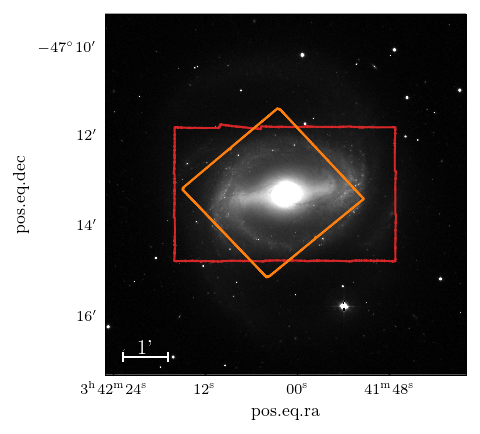

In [88]:
from astropy.nddata import Cutout2D

WFI_cutout = Cutout2D(WFI.data,p['SkyCoord'],size=8*u.arcmin,wcs=WFI.wcs)

# project from muse to hst coordinates
reg_muse_wfi = reg_muse_sky.to_pixel(WFI_cutout.wcs)
reg_hst_wfi  = reg_hst_sky.to_pixel(WFI_cutout.wcs)

# plot image
ax = quick_plot(WFI_cutout,figsize=(single_column,single_column),cmap=plt.cm.gray)
add_scale(ax,u.arcmin,label="1'",color='white',fontsize=10)

reg_muse_wfi.plot(ax=ax,ec='tab:red',label='MUSE')
reg_hst_wfi.plot(ax=ax,ec='tab:orange',label='HST')
#ax.set(xlim=[3000,11000],ylim=[3000,11000])

plt.show()

### Match the cluster and nebulae catalgoues

we look up the value (=region_ID) in the spatial nebulae mask for each position in the cluster catalogue and asign this value to the cluster.

768 inside and 1387 outside of nebulae
15 isolated clusters (no other objects in nebulae)


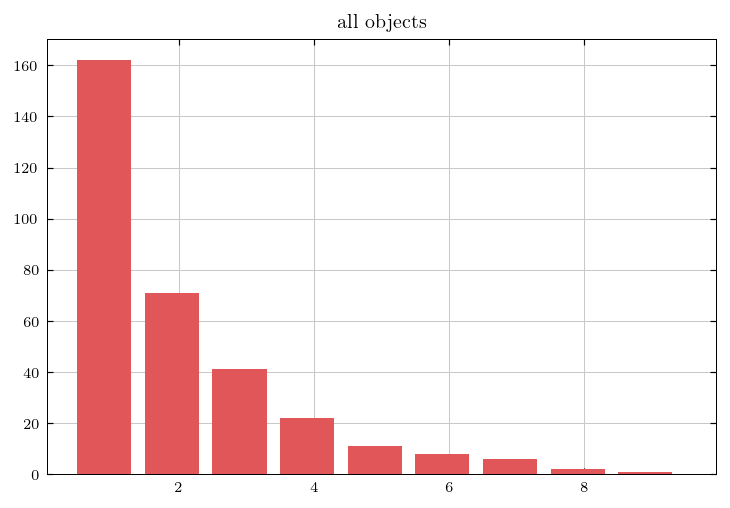

In [89]:
def get_value(data,x,y):
    shape = data.shape
    
    out = []
    for j,i in zip(x,y):
        if 0<i<shape[0] and 0<j<shape[1]:
            out.append(data[int(i),int(j)])
        else:
            out.append(np.nan)
    return out

hst_all_objects['in_frame'] = reg_muse_sky.contains(hst_all_objects['SkyCoord'],nebulae_mask.wcs)
hst_all_objects['MUSE_X'],hst_all_objects['MUSE_Y'] = hst_all_objects['SkyCoord'].to_pixel(nebulae_mask.wcs)

hst_all_objects['region_ID'] = np.nan
hst_all_objects['region_ID'][hst_all_objects['in_frame']] = get_value(nebulae_mask.data,x=hst_all_objects['MUSE_X'][hst_all_objects['in_frame']],y=hst_all_objects['MUSE_Y'][hst_all_objects['in_frame']])
# we exclude clusters in PNe and SNRs 
hst_all_objects['region_ID'][~np.isin(hst_all_objects['region_ID'],HII_regions['region_ID'])] = np.nan

region_ID = hst_all_objects['region_ID']
print(f'{np.sum(~np.isnan(region_ID))} inside and {np.sum(np.isnan(region_ID))} outside of nebulae')
unique, counts = np.unique(region_ID[~np.isnan(region_ID)],return_counts=True)
isolated_clusters = filter_table(hst_all_objects[np.isin(hst_all_objects['region_ID'],unique[counts==1])],CLUSTER_CLASS=[1,2,3])
print(f'{len(isolated_clusters)} isolated clusters (no other objects in nebulae)')

hist,bins,_=plt.hist(counts,bins=np.arange(0.5,10.5,1),width=0.8)
plt.title('all objects')

plt.grid()
plt.show()

#### Plot cutout of single region

this function plots a cutout for one region in different filters. Overplotted are the detected clusters and nebulae (green circles are unclassified clusters and blue circles are classified clusters. Solid regions are HII-regions and dashed regions are other emission line nebulae like PNe or SNRs). 

In [11]:
from cluster.plot import plot_cluster_nebulae

path = data_ext / 'MUSE_DR2' / 'filterImages' 

sdss_g, h = fits.getdata(path / f'{name}_IMAGE_FOV_SDSS_g_WCS_Pall_mad.fits',header=True)
sdss_r, h = fits.getdata(path / f'{name}_IMAGE_FOV_SDSS_r_WCS_Pall_mad.fits',header=True)
sdss_i, h = fits.getdata(path / f'{name}_IMAGE_FOV_SDSS_i_WCS_Pall_mad.fits',header=True)

save image to file ..\reports\NGC1433\NGC1433_region.pdf


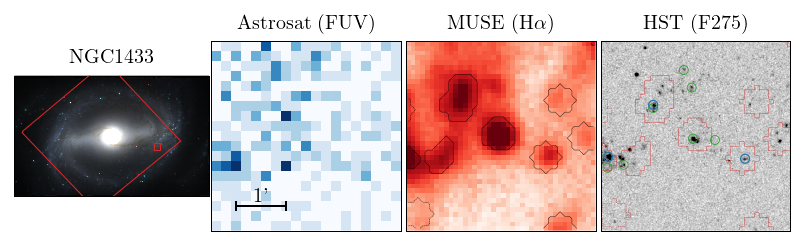

In [91]:
# 37,77
position = HII_regions['SkyCoord'][HII_regions['region_ID']==77][0]
#position = isolated_clusters['SkyCoord'][0]
#position = HII_regions['SkyCoord'][np.isin(HII_regions['region_ID'],hst_all_objects['region_ID'])][39]
filename = basedir/'reports'/name/f'{name}_region'

plot_cluster_nebulae(name,position,8*u.arcsec,
                     F275,Halpha,astrosat,
                     sdss_g,sdss_r,sdss_i,
                     reg_hst_sky,nebulae_mask,
                     HII_regions,hst_all_objects,
                     filename=filename)

For our analysis we require nebulae that are clearly associated with one cluster. Here we plot a cutout for each of those clusters with the detected nebulae and clusters overlayed

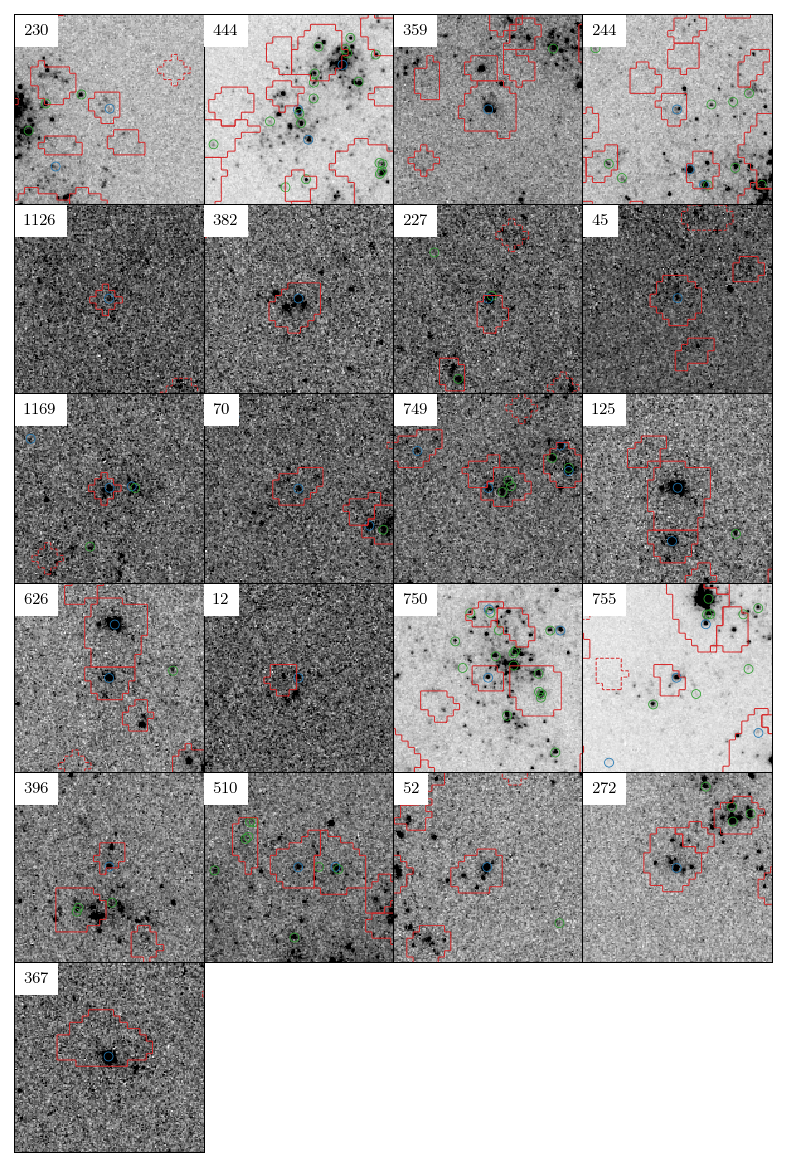

In [84]:
from cluster.plot import plot_cutouts

#nebulae.sort(['HA6562_FLUX'])

sample = isolated_clusters
filename = basedir/'reports'/name/f'isolated_clusters_F275_{name}'
positions = sample['SkyCoord']
labels = sample['region_ID']

plot_cutouts(positions,F275,nebulae_mask,HII_regions['region_ID'],
             hst_all_objects,labels,filename=filename)


finally we plot the position of those "isolated clusters"

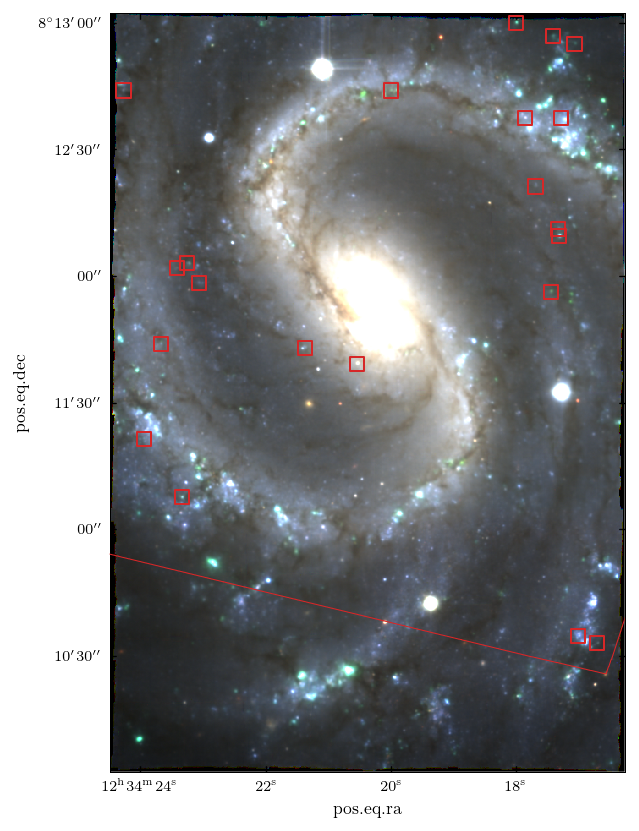

In [85]:
from pnlf.plot import create_RGB

fig = plt.figure(figsize=(two_column,two_column))
ax1  = fig.add_subplot(111,projection=Halpha.wcs)

gri = create_RGB(sdss_i,sdss_r,sdss_g,percentile=[98,98,98])

# show image of the entire galaxy
ax1.imshow(gri)
reg_hst_muse  = reg_hst_sky.to_pixel(Halpha.wcs)
reg_hst_muse.plot(ax=ax1,ec='tab:red',label='HST',lw=0.5)
x,y = isolated_clusters['SkyCoord'].to_pixel(Halpha.wcs)
ax1.scatter(x,y,marker='s',facecolors='none',s=50,lw=1,color='tab:red')
plt.savefig(basedir/'reports'/name/f'{name}_location_isolated_clusters.png')
plt.show()

for real clusters: 88 inside and 747 outside of nebulae

for all objects: 1117 inside and 7562 outside of nebulae

#### Combine the two catalgoues

In [9]:
with fits.open(basedir/'data'/'interim'/f'{name}_Clusters+Nebulae.fits') as hdul:
    catalogue = Table(hdul[1].data)

run only when something has changed and you want to save a new catalogue

In [86]:
from astropy.table import join
from cluster.regions import find_sky_region

reg_muse_pix, reg_muse_sky = find_sky_region(nebulae_mask.mask.astype(int),wcs=nebulae_mask.wcs)
    
hst_all_objects['in_frame'] = reg_muse_sky.contains(hst_all_objects['SkyCoord'],nebulae_mask.wcs)
hst_all_objects['MUSE_X'],hst_all_objects['MUSE_Y'] = hst_all_objects['SkyCoord'].to_pixel(nebulae_mask.wcs)

hst_all_objects['region_ID'] = np.nan
hst_all_objects['region_ID'][hst_all_objects['in_frame']] = get_value(nebulae_mask.data,x=hst_all_objects['MUSE_X'][hst_all_objects['in_frame']],y=hst_all_objects['MUSE_Y'][hst_all_objects['in_frame']])
# we exclude clusters in PNe and SNRs 
hst_all_objects['region_ID'][~np.isin(hst_all_objects['region_ID'],HII_regions['region_ID'])] = np.nan

region_ID = hst_all_objects['region_ID']
print(f'{np.sum(~np.isnan(region_ID))} inside and {np.sum(np.isnan(region_ID))} outside of nebulae')
unique, counts = np.unique(region_ID[~np.isnan(region_ID)],return_counts=True)
isolated_clusters = filter_table(hst_all_objects[np.isin(hst_all_objects['region_ID'],unique[counts==1])],CLUSTER_CLASS=[1,2,3])
print(f'{len(isolated_clusters)} isolated clusters (no other objects in nebulae)')

isolated_nebulae = nebulae[np.isin(nebulae['region_ID'],isolated_clusters['region_ID'])]

catalogue = join(isolated_clusters,isolated_nebulae,keys='region_ID')
#catalogue['met_scal'][0]

del catalogue[['SkyCoord_1','SkyCoord_2']]

# write to file
primary_hdu = fits.PrimaryHDU()
table_hdu   = fits.BinTableHDU(catalogue)
hdul = fits.HDUList([primary_hdu, table_hdu])
hdul.writeto(basedir/'data'/'interim'/f'{name}_Clusters+Nebulae.fits',overwrite=True)

687 inside and 1480 outside of nebulae
21 isolated clusters (no other objects in nebulae)


### Correlations in combined catalogues

In [10]:
# create a new table
if 'catalogue' in locals(): del catalogue
    
for filename in [x for x in (basedir/'data'/'interim').iterdir() if  x.stem.endswith('Clusters+Nebulae')]:
    
    # cluster catalogues
    with fits.open(filename) as hdul:
        tbl = Table(hdul[1].data) 
 
    if 'catalogue' in locals():
        catalogue = vstack([catalogue,tbl])
    else:
        catalogue = tbl

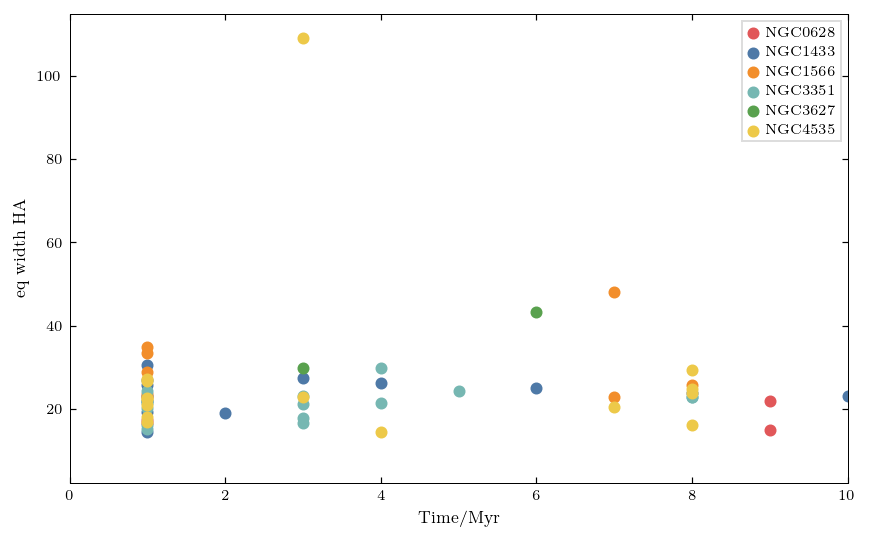

In [25]:
fig,ax=plt.subplots(figsize=(two_column,two_column/1.618))

for name in np.unique(catalogue['gal_name']):
    tmp = catalogue[catalogue['gal_name']==name]
    ax.scatter(tmp['AGE_MINCHISQ'],tmp['HA6562_SIGMA'],label=name)

ax.legend()
ax.set(xlabel='Time/Myr',ylabel='eq width HA',xlim=[0,10])

plt.show()

In [45]:
tmp = catalogue[]

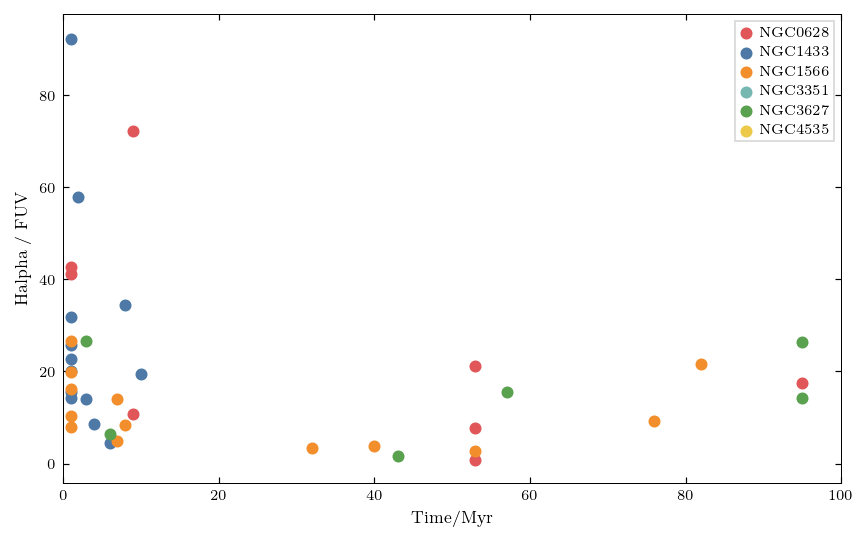

In [48]:
fig,ax=plt.subplots(figsize=(two_column,two_column/1.618))

for name in np.unique(catalogue['gal_name']):
    criteria = (catalogue['AGE_MINCHISQ']<20) & (catalogue['MASS_MINCHISQ']>1e3)
    tmp = catalogue[(catalogue['gal_name']==name)]
    ax.scatter(tmp['AGE_MINCHISQ'],tmp['HA/FUV'],label=name)

ax.legend()
ax.set(xlabel='Time/Myr',ylabel='Halpha / FUV',xlim=[0,100])

plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(single_column,single_column))

for name in np.unique(catalogue['gal_name']):
    tmp = catalogue[catalogue['gal_name']==name]
    ax.scatter(tmp['[SIII]/[SII]'],tmp['HA/FUV'],label=name)

ax.legend()
ax.set(xlabel='[SIII]/[SII]',ylabel='Halpha / FUV',xscale='log',yscale='log',xlim=[1e-2,1],ylim=[2,300])

plt.show()

In [ ]:
filename = basedir/'reports'/f'{name}_age_over_SII.pdf'

fig, ax = plt.subplots(figsize=(single_column,single_column))
ax.scatter(catalogue['age'],catalogue['HA/FUV'])
ax.set(xlim=(0,12))
plt.show()

### Use the brightest nebulae

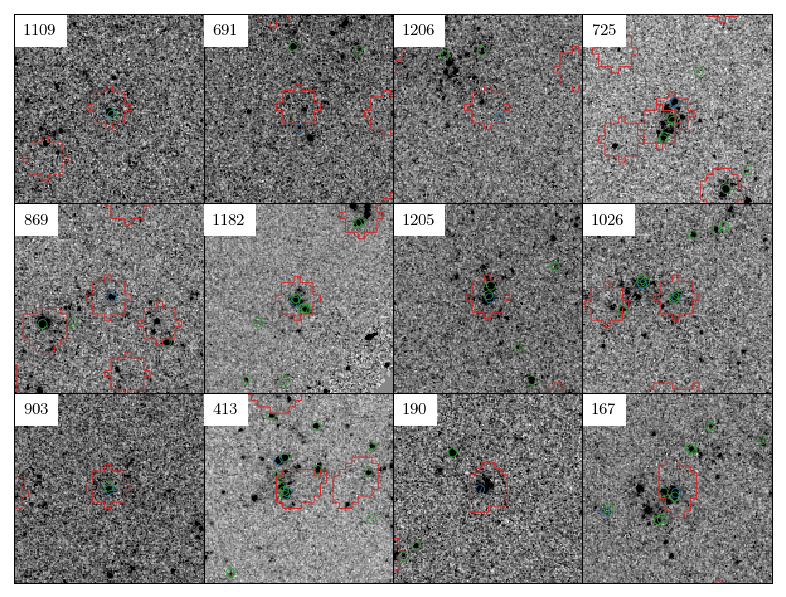

In [70]:
from cluster.plot import plot_cutouts

nebulae.sort(['HA6562_FLUX'])

sample = nebulae[np.isin(nebulae['region_ID'],clusters['region_ID'])][:12]
filename = None #basedir/'reports'/f'brightest_nebulae_{name}'
positions = sample['SkyCoord']
labels = sample['region_ID']

plot_cutouts(positions,F275,nebulae_mask,HII_regions['region_ID'],
             hst_all_objects,labels,filename=filename)


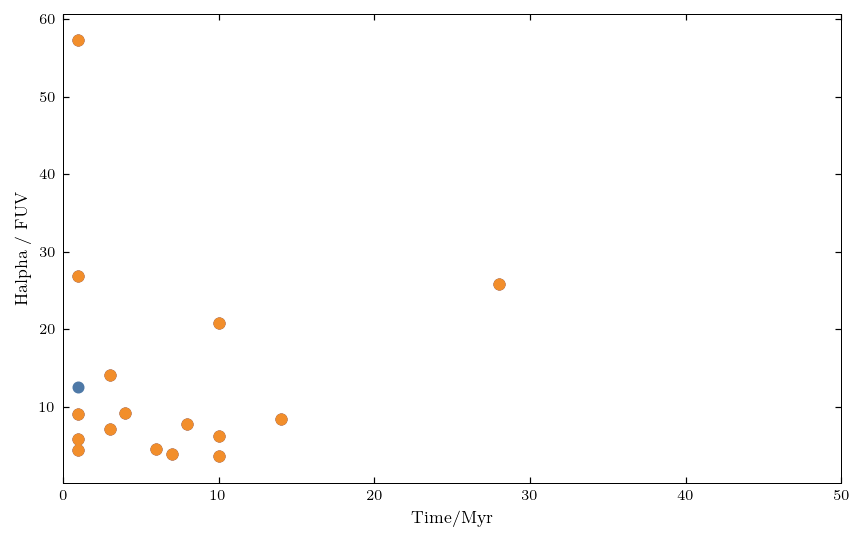

In [74]:
sample = nebulae[np.isin(nebulae['region_ID'],clusters['region_ID'])][:20]

age_med = []
age_min = []
age_max = []

for region_ID in sample['region_ID']:
    tmp = clusters[clusters['region_ID']==region_ID]
    
    age_med.append(np.median(tmp['AGE_MINCHISQ']))
    age_min.append(np.min(tmp['AGE_MINCHISQ']))
    age_max.append(np.max(tmp['AGE_MINCHISQ']))
    
fig,ax=plt.subplots(figsize=(two_column,two_column/1.618))

ax.scatter(age_med,sample['HA/FUV'],label='median')
ax.scatter(age_min,sample['HA/FUV'],label='min')
ax.scatter(age_max,sample['HA/FUV'],label='max')

ax.set(xlabel='Time/Myr',ylabel='Halpha / FUV',xlim=[0,50])

plt.show()

## Compare with SIGNALS

In [41]:
if name!='NGC0628':
    raise ValueError(f'current Galaxy is {name} and not NGC0628')

from cluster.regions import find_sky_region

reg_muse_pix, reg_muse_sky = find_sky_region(nebulae_mask.mask.astype(int),wcs=nebulae_mask.wcs)

with open(basedir/'data'/'external'/'columns.txt') as f:
    txt = f.read()
names = txt.split('\n')

with fits.open(basedir/'data'/'external'/'NGC628_catalog.fits') as hdul:
    signals = Table(hdul[0].data,names=names)
signals['SkyCoord'] = SkyCoord(signals['RA']*u.degree,signals['DEC']*u.degree)

signals['in_frame'] = reg_muse_sky.contains(signals['SkyCoord'],nebulae_mask.wcs)

In [83]:
def calculate_ratios(tbl):
    '''
    'log(NII6583/HA)',
    'log(SII6716+6731/HA)',
    'log(SII6716+6731/NII6583)',
    'log(OIII5007/HB)',
    'log(OII3727/HB)',
    'log(OII3727+OII5007/HB)',
    'log(OIII5007/OII3727 )',
    'log(OIII5007/NII6583 )',
    'log(OII3727/NII6583)',
    'log(SII6717/SII6731)'
    ''' 
    
    with np.errstate(divide='ignore'):
        tbl['NII6583/HA'] = np.log10(tbl['NII6583_FLUX']/tbl['HA6562_FLUX'])
        tbl['SII6716+6731/HA'] = np.log10((tbl['SII6716_FLUX']+tbl['SII6730_FLUX'])/tbl['HA6562_FLUX'])
        tbl['SII6716+6731/NII6583'] = np.log10((tbl['SII6716_FLUX']+tbl['SII6730_FLUX'])/tbl['NII6583_FLUX'])
        tbl['OIII5007/HB'] = np.log10(tbl['OIII5006_FLUX']/tbl['HB4861_FLUX'])
        tbl['OIII5007/NII6583'] = np.log10(tbl['OIII5006_FLUX']/tbl['NII6583_FLUX'])
        tbl['SII6717/SII6731'] = np.log10(tbl['SII6716_FLUX']/tbl['SII6730_FLUX'])    

    return tbl

HII_regions = calculate_ratios(HII_regions)

In [84]:
from astropy.coordinates import match_coordinates_sky, Angle

matchcoord = HII_regions[HII_regions['flag_point_source']==1]
catalogcoord = signals[signals['in_frame']]

idx,sep,_=match_coordinates_sky(matchcoord['SkyCoord'],catalogcoord['SkyCoord'])
crit = sep.__lt__(Angle('0.8"'))

lines = ['log(NII6583/HA)','log(SII6716+6731/HA)','log(SII6716+6731/NII6583)',
             'log(OIII5007/HB)','log(OIII5007/NII6583)','log(SII6717/SII6731)']

for line in lines:
    matchcoord[line] = catalogcoord[idx][line]
matchcoord = matchcoord[crit]

#print(f'SIGNALS in MUSE frame: {np.sum(catalogcoord["in_frame"])}')
print(f'matches {np.sum(crit)}')

matches 104


In [10]:
from region import Regions
        
muse_regions = Regions(mask=nebulae_mask.data,projection=nebulae_mask.meta,bkg=-1)

INFO:region.core:initialized with 1818 regions


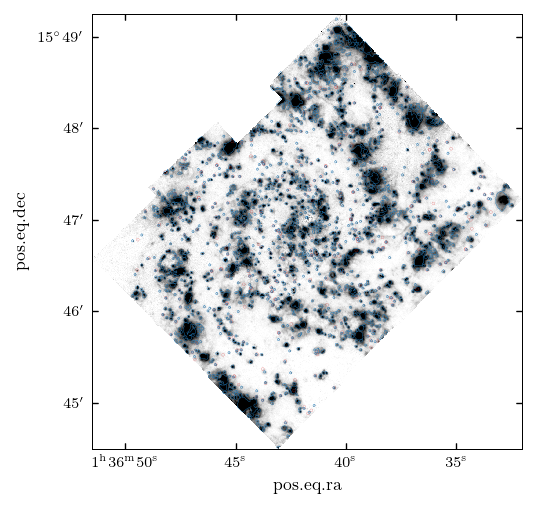

In [79]:
fig=plt.figure()
ax=fig.add_subplot(projection=Halpha.wcs)

norm = simple_norm(Halpha.data,clip=False,stretch='asinh',percent=90)
ax.imshow(Halpha.data,norm=norm,cmap=plt.cm.Greys)

x,y = catalogcoord[idx]['SkyCoord'].to_pixel(Halpha.wcs)
plt.scatter(x,y,marker='o',fc='none',ec='tab:red',s=2,lw=0.1)

for coords in muse_regions.contours: 
    ax.plot(coords[:,1],coords[:,0],color='tab:blue',lw=0.2)

plt.savefig(basedir/'reports'/name/'signals_nebulae.pdf',dpi=600)

plt.show()

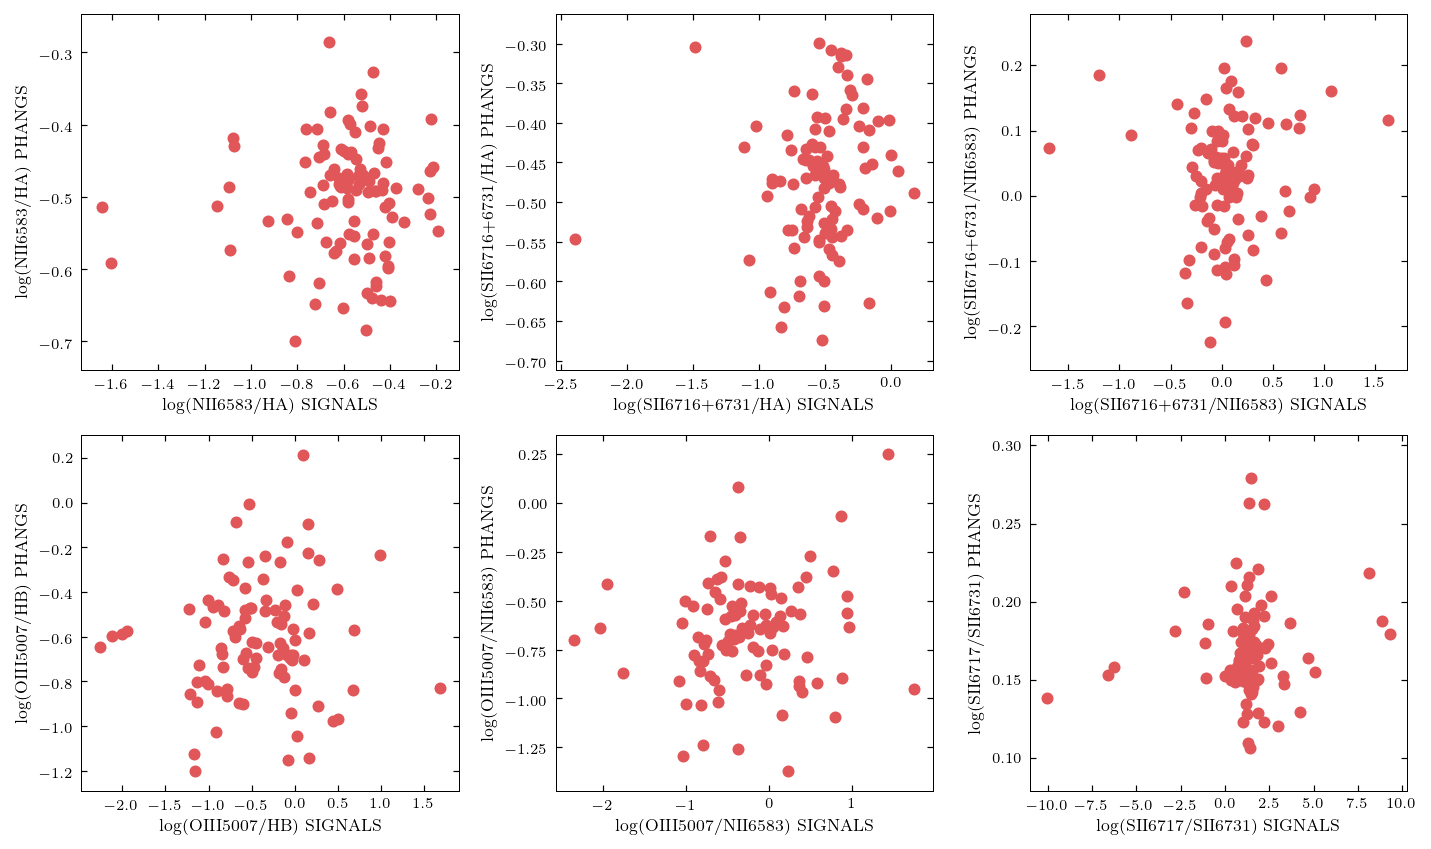

In [85]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(10,6))

axes_iter=iter(axes.flatten())

for line in lines:
    ax = next(axes_iter)
    
    ax.scatter(matchcoord[line],matchcoord[line[4:-1]])
    #ax.plot([-3,3],[-3,3])
    ax.set(xlabel=f'{line} SIGNALS',ylabel=f'{line} PHANGS')
plt.tight_layout()
plt.show()

## Starburst99

compare our observations with simulated data

**Note**: the GENEVAHIGH 23 (Z=0.008) model used a metallicity of 0.02 for the high resolution models 

In [11]:
from starburst.core import Cluster

cluster = Cluster(stellar_model='GENEVAHIGH',metallicity=0.008)

INFO:starburst.core:model 23 (GENEVAHIGH for Z=0.008)
INFO:starburst.core:loading tables from archive
INFO:starburst.io:loading all tables
INFO:starburst.io:all tables read in
INFO:starburst.core:measuring FUV from spectrum


### Filter response curve

to get the FUV flux by integrating the spectrum. The curves are from the [astrosat website](https://uvit.iiap.res.in/Instrument/Filters)



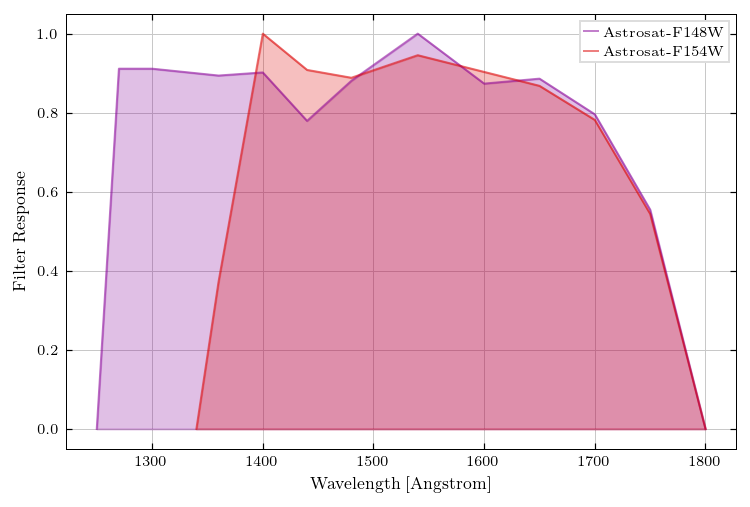

In [8]:
from speclite.filters import FilterResponse, load_filters, plot_filters

response_curve = ascii.read(basedir/'data'/'external'/'astrosat_response_curve.txt',
                                     names=['wavelength','EA','Filter'])

F148W_mask = response_curve['Filter']=='F148W'
F148W_lam = response_curve['wavelength'][F148W_mask]*u.angstrom
F148W_res = response_curve['EA'][F148W_mask] / max(response_curve['EA'][F148W_mask])
F148W = FilterResponse(F148W_lam,F148W_res,meta=dict(group_name='Astrosat',band_name='F148W'))

F154W_mask = response_curve['Filter']=='F154W'
F154W_lam  = response_curve['wavelength'][F154W_mask]*u.angstrom
F154W_res  = response_curve['EA'][F154W_mask] / max(response_curve['EA'][F154W_mask])
F154W = FilterResponse(F154W_lam,F154W_res,meta=dict(group_name='Astrosat',band_name='F154W'))

astrosat_filter = load_filters('Astrosat-F148W', 'Astrosat-F154W')
plot_filters(astrosat_filter)

### Compare Halpha and FUV

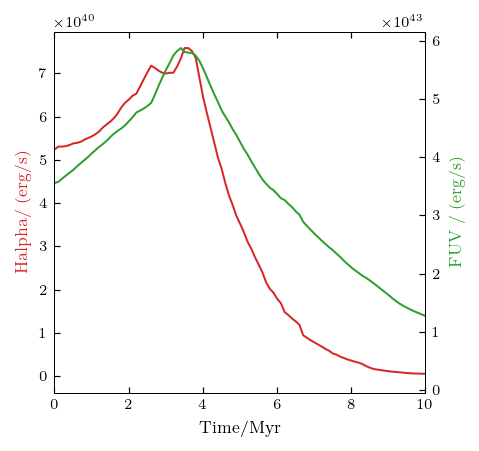

In [32]:
fig,ax1 =plt.subplots(figsize=(single_column,single_column))
Halpha  = cluster.ewidth['Luminosity_H_A']
time_HA = cluster.ewidth['Time']

ax1.plot(time_HA/1e6,Halpha,color='tab:red')
ax1.set_ylabel('Halpha/ (erg/s)',color='tab:red')
ax1.set(xlabel='Time/Myr')

ax2 = ax1.twinx() 
ax2.plot(time_FUV/1e6,FUV,color='tab:green')
ax2.set_ylabel('FUV / (erg/s)',color='tab:green')
ax2.set(xlabel='Time/Myr',xlim=[0,10])
plt.show()

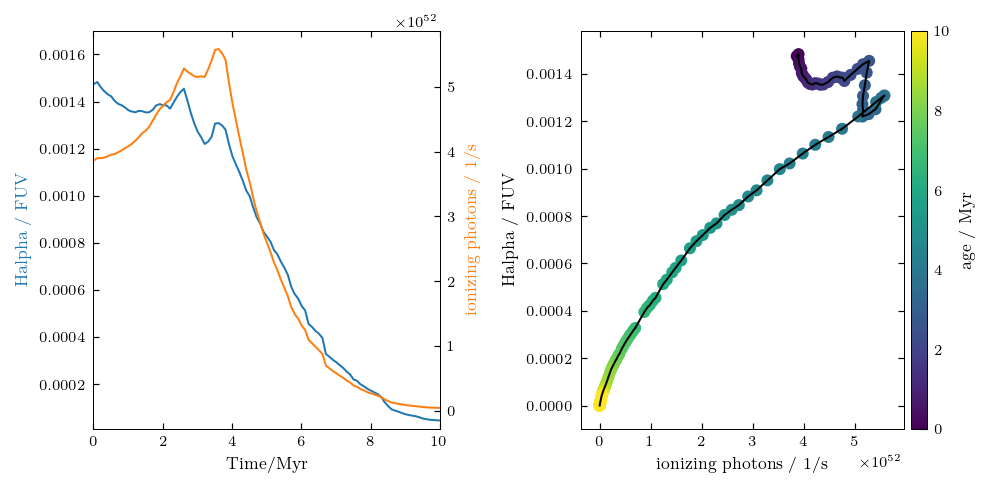

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

FUV_int = np.interp(time_HA,time_FUV,FUV)

fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(two_column,two_column/2))
ax1.plot(time_HA/1e6,Halpha/FUV_int,color='tab:blue')
ax1.set_ylabel('Halpha / FUV',color='tab:blue')
ax1.set(xlim=[0,3],ylim=[1e-5,0.0017],xlabel='Time/Myr')

axt = ax1.twinx()
quanta = cluster.quanta
axt.plot(quanta['Time']/1e6,quanta['HI_rate'],color='tab:orange')
axt.set_ylabel('ionizing photons / 1/s',color='tab:orange')
axt.set(xlim=[0,10])

HI_rate_int = np.interp(time_HA,quanta['Time'],quanta['HI_rate'])

ax2.plot(HI_rate_int,Halpha/FUV_int,color='black')
sc = ax2.scatter(HI_rate_int,Halpha/FUV_int,c=time_HA/1e6,vmin=0,vmax=10)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(sc,cax=cax,label='age / Myr',pad=-1)

ax2.set(xlabel='ionizing photons / 1/s',ylabel='Halpha / FUV')

plt.tight_layout()
plt.show()

In [ ]:
fig,ax1 =plt.subplots(figsize=(single_column,single_column))

ax1.plot(time_HA/1e6,Halpha/FUV_int,color='black')
#sc = ax1.scatter(FUV_int,Halpha,c=time_HA/1e6,vmin=0,vmax=3)
#fig.colorbar(sc,ax=ax1,label='age / Myr')
ax1.set(ylabel='Halpha/ FUV',xlabel='time / Myr',xlim=[0,10])
plt.show()

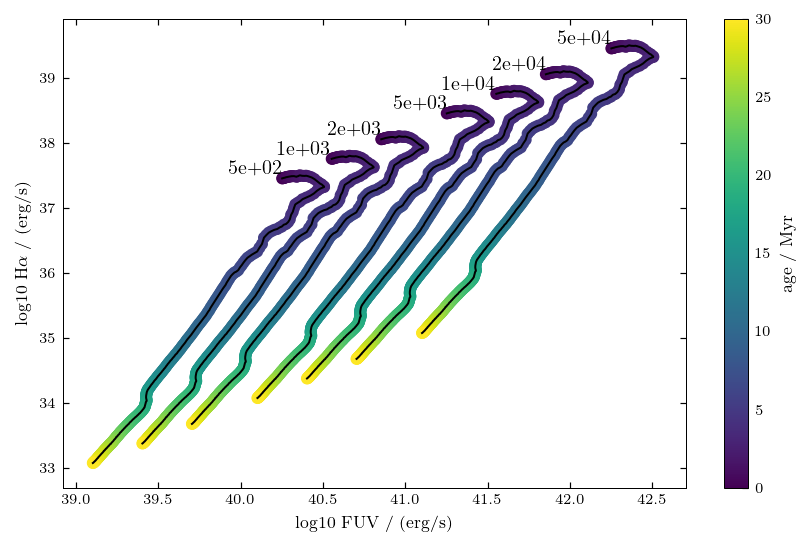

In [54]:
fig,ax1 =plt.subplots(figsize=(two_column,two_column/1.618))

for mass in [5e2,1e3,2e3,5e3,1e4,2e4,5e4]:
    
    scaled_cluster = cluster.scale(mass)
    
    Halpha  = scaled_cluster.ewidth['Luminosity_H_A']
    time_HA = scaled_cluster.ewidth['Time']
    FUV = scaled_cluster.FUV['FUV']
    
    ax1.plot(np.log10(FUV.value),np.log10(Halpha.value),color='black')
    ax1.text(np.log10(FUV.value)[0],np.log10(Halpha.value)[0],f'{mass:.0g}  ',
            horizontalalignment='right',verticalalignment='bottom')
    sc = ax1.scatter(np.log10(FUV.value),np.log10(Halpha.value),c=time_HA/1e6,vmin=0,vmax=30)

ax1.set(ylabel=r'log10 H$\alpha$ / (erg/s)',xlabel='log10 FUV / (erg/s)')
fig.colorbar(sc,label='age / Myr')
plt.show()

In [12]:
clusters = {}
for m in [23,53,63,24,54,64]:
    clusters[m] = Cluster(stellar_model=m)

INFO:starburst.core:model 23 (GENEVAHIGH for Z=0.008)
INFO:starburst.core:loading tables from archive
INFO:starburst.io:loading all tables
INFO:starburst.io:all tables read in
INFO:starburst.core:measuring FUV from spectrum
INFO:starburst.core:model 53 (GENEVAv00 for Z=0.008)
INFO:starburst.core:loading tables from archive
INFO:starburst.io:loading all tables
INFO:starburst.io:all tables read in
INFO:starburst.core:measuring FUV from spectrum
INFO:starburst.core:model 63 (GENEVAv40 for Z=0.008)
INFO:starburst.core:loading tables from archive
INFO:starburst.io:loading all tables
INFO:starburst.io:all tables read in
INFO:starburst.core:measuring FUV from spectrum
INFO:starburst.core:model 24 (GENEVAHIGH for Z=0.02)
INFO:starburst.core:loading tables from archive
INFO:starburst.io:loading all tables
INFO:starburst.io:all tables read in
INFO:starburst.core:measuring FUV from spectrum
INFO:starburst.core:model 54 (GENEVAv00 for Z=0.014)
INFO:starburst.core:loading tables from archive
INFO:s

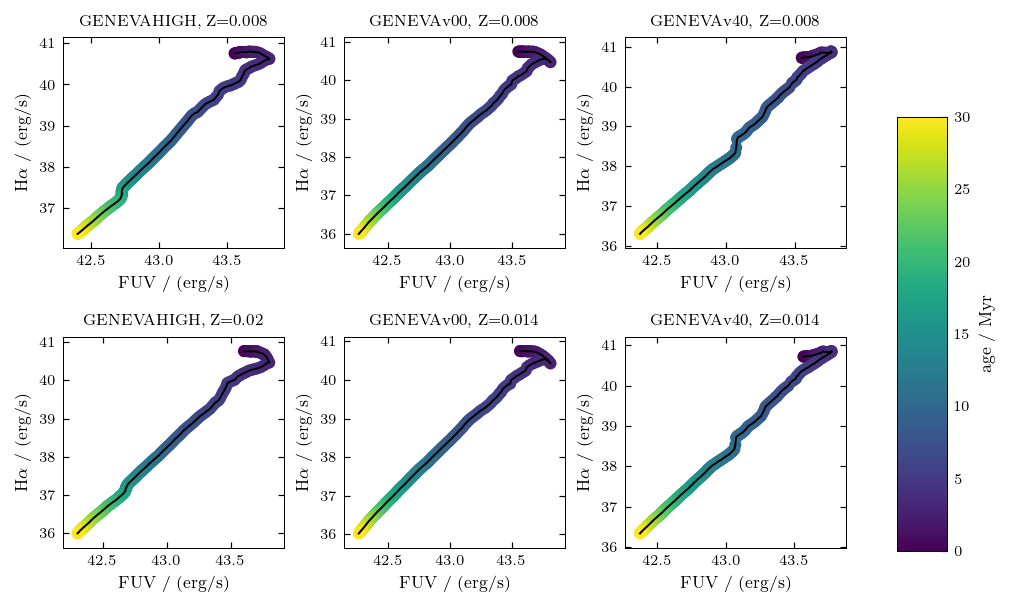

In [55]:
fig,axes =plt.subplots(nrows=2,ncols=3,figsize=(two_column,two_column/1.618))
axes_iter = iter(axes.flatten())

for m in [23,53,63,24,54,64]:
    
    ax = next(axes_iter)
    cl = clusters[m]
    
    Halpha  = cl.ewidth['Luminosity_H_A']
    time_HA = cl.ewidth['Time']
    FUV = cl.FUV['FUV']
    
    label = f'{cl.stellar_model}, Z={cl.metallicity}'
    ax.plot(np.log10(FUV.value),np.log10(Halpha.value),color='black')
    #t = ax.text(0.05,0.9,label, transform=ax.transAxes,color='black',fontsize=8)
    ax.set_title(label,fontsize=8)
    sc = ax.scatter(np.log10(FUV.value),np.log10(Halpha.value),c=time_HA/1e6,vmin=0,vmax=30)

    ax.set(ylabel=r'H$\alpha$ / (erg/s)',xlabel='FUV / (erg/s)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.7])
fig.colorbar(sc, cax=cbar_ax,label='age / Myr')

plt.show()

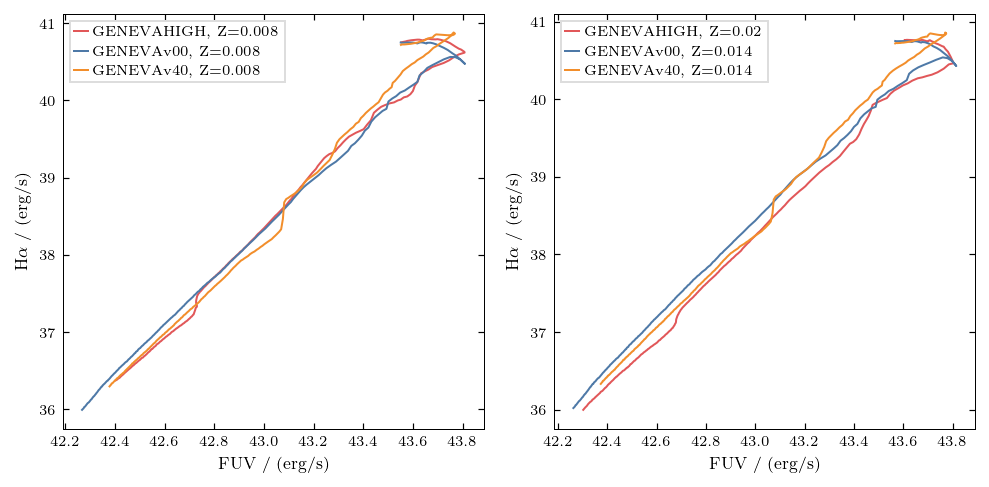

In [54]:
fig,(ax1,ax2) =plt.subplots(nrows=1,ncols=2,figsize=(two_column,two_column/2))

for m in [23,53,63]:
    
    cl = clusters[m]
    
    Halpha  = cl.ewidth['Luminosity_H_A']
    time_HA = cl.ewidth['Time']
    FUV = cl.FUV['FUV']
    
    label = f'{cl.stellar_model}, Z={cl.metallicity}'
    ax1.plot(np.log10(FUV.value),np.log10(Halpha.value),label=label)
    #t = ax.text(0.05,0.9,label, transform=ax.transAxes,color='black',fontsize=8)
    #sc = ax.scatter(np.log10(FUV.value),np.log10(Halpha.value),c=time_HA/1e6,vmin=0,vmax=30)

ax1.set(ylabel=r'H$\alpha$ / (erg/s)',xlabel='FUV / (erg/s)')
ax1.legend()

for m in [24,54,64]:
    
    cl = clusters[m]
    
    Halpha  = cl.ewidth['Luminosity_H_A']
    time_HA = cl.ewidth['Time']
    FUV = cl.FUV['FUV']

    label = f'{cl.stellar_model}, Z={cl.metallicity}'
    ax2.plot(np.log10(FUV.value),np.log10(Halpha.value),label=label)
    #t = ax.text(0.05,0.9,label, transform=ax.transAxes,color='black',fontsize=8)
    #sc = ax.scatter(np.log10(FUV.value),np.log10(Halpha.value),c=time_HA/1e6,vmin=0,vmax=30)

ax2.set(ylabel=r'H$\alpha$ / (erg/s)',xlabel='FUV / (erg/s)')
ax2.legend()
    
plt.tight_layout()


plt.show()

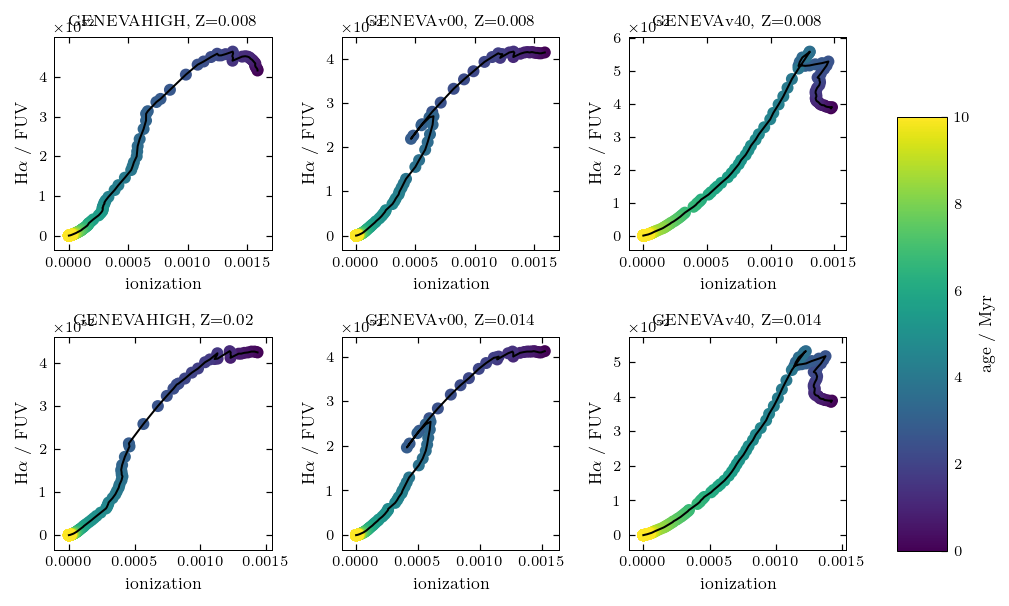

In [61]:
fig,axes =plt.subplots(nrows=2,ncols=3,figsize=(two_column,two_column/1.618))
axes_iter = iter(axes.flatten())

for m in [23,53,63,24,54,64]:
    
    ax = next(axes_iter)
    cl = clusters[m]
    
    Halpha  = cl.ewidth['Luminosity_H_A']
    time_HA = cl.ewidth['Time']
    FUV = cl.FUV['FUV']
    ionizing = cl.quanta['HI_rate']
  
    label = f'{cl.stellar_model}, Z={cl.metallicity}'
    ax.plot(Halpha/FUV,ionizing,color='black')
    #t = ax.text(0.05,0.9,label, transform=ax.transAxes,color='black',fontsize=8)
    ax.set_title(label,fontsize=8)
    sc = ax.scatter(Halpha/FUV,ionizing,c=time_HA/1e6,vmin=0,vmax=10)

    ax.set(ylabel=r'H$\alpha$ / FUV',xlabel='ionization')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.7])
fig.colorbar(sc, cax=cbar_ax,label='age / Myr')

plt.show()

### Compare observations to simulations

In [95]:
catalogue['distance'] = np.nan
for name in np.unique(catalogue['gal_name']):
    catalogue['distance'][catalogue['gal_name']==name] = (sample_table.loc[name]['Distance']*u.Mpc).to(u.cm)

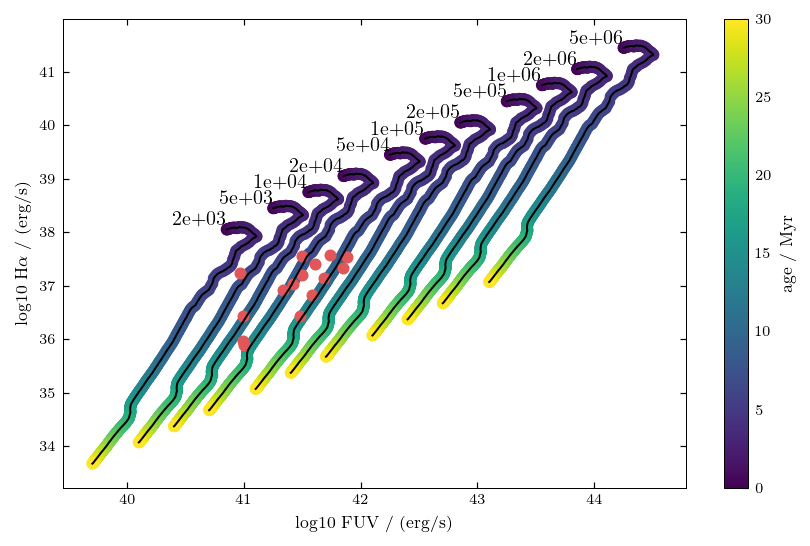

In [98]:
fig,ax1 =plt.subplots(figsize=(two_column,two_column/1.618))

for mass in [2e3,5e3,1e4,2e4,5e4,1e5,2e5,5e5,1e6,2e6,5e6]:
    
    scaled_cluster = cluster.scale(mass)
    
    Halpha  = scaled_cluster.ewidth['Luminosity_H_A']
    time_HA = scaled_cluster.ewidth['Time']
    FUV = scaled_cluster.FUV['FUV']
    
    ax1.plot(np.log10(FUV.value),np.log10(Halpha.value),color='black')
    ax1.text(np.log10(FUV.value)[0],np.log10(Halpha.value)[0],f'{mass:.0g}  ',
            horizontalalignment='right',verticalalignment='bottom')
    sc = ax1.scatter(np.log10(FUV.value),np.log10(Halpha.value),c=time_HA/1e6,vmin=0,vmax=30)

Halpha_FLUX = ((catalogue['HA6562_FLUX_CORR']*1e-20*u.erg/u.s/u.cm**2) * 4*np.pi*catalogue['distance']**2).value
FUV_FLUX = 5e5*((catalogue['FUV_FLUX_CORR']*1e-20*u.erg/u.s/u.cm**2) * 4*np.pi*catalogue['distance']**2).value
ax1.scatter(np.log10(FUV_FLUX),np.log10(Halpha_FLUX))

ax1.set(ylabel=r'log10 H$\alpha$ / (erg/s)',xlabel='log10 FUV / (erg/s)')
fig.colorbar(sc,label='age / Myr')
plt.show()

create the grid to compare the observations to

In [99]:
n_time = len(cluster.ewidth['Time'])
n_mass = 1000

mass_min = 5e3
mass_max = 1e6

mass_grid = np.linspace(mass_min,mass_max,n_mass)

HA_grid = np.zeros((n_time,n_mass))
FUV_grid = np.zeros((n_time,n_mass))

for i,mass in enumerate(mass_grid):
    
    scaled_cluster = cluster.scale(mass)
    
    HA_grid[:,i]  = scaled_cluster.ewidth['Luminosity_H_A']
    FUV_grid[:,i] = scaled_cluster.FUV['FUV']

time = scaled_cluster.FUV['Time']

In [101]:
#distance = (sample_table.loc[name]['Distance']*u.Mpc).to(u.cm)

mass, age, chi2 = [],[],[]
for row in catalogue:
    
    Halpha_FLUX = ((row['HA6562_FLUX_CORR']*1e-20*u.erg/u.s/u.cm**2) * 4*np.pi*row['distance']**2).value
    Halpha_ERR  = ((row['HA6562_FLUX_CORR_ERR']*1e-20*u.erg/u.s/u.cm**2) * 4*np.pi*row['distance']**2).value
    
    FUV_FLUX = 1e6*((row['FUV_FLUX_CORR']*1e-20*u.erg/u.s/u.cm**2) * 4*np.pi*row['distance']**2).value
    FUV_ERR  = ((row['FUV_FLUX_CORR_ERR']*1e-20*u.erg/u.s/u.cm**2) * 4*np.pi*row['distance']**2).value
    
    chi2_grid = (Halpha_FLUX-HA_grid)**2/Halpha_ERR**2 + (FUV_FLUX-FUV_grid)**2/FUV_ERR**2
    
    row,col = np.unravel_index(chi2_grid.argmin(), chi2_grid.shape)
    mass.append(mass_grid[col])
    age.append(time[row].value)
    chi2.append(np.min(chi2_grid))
    

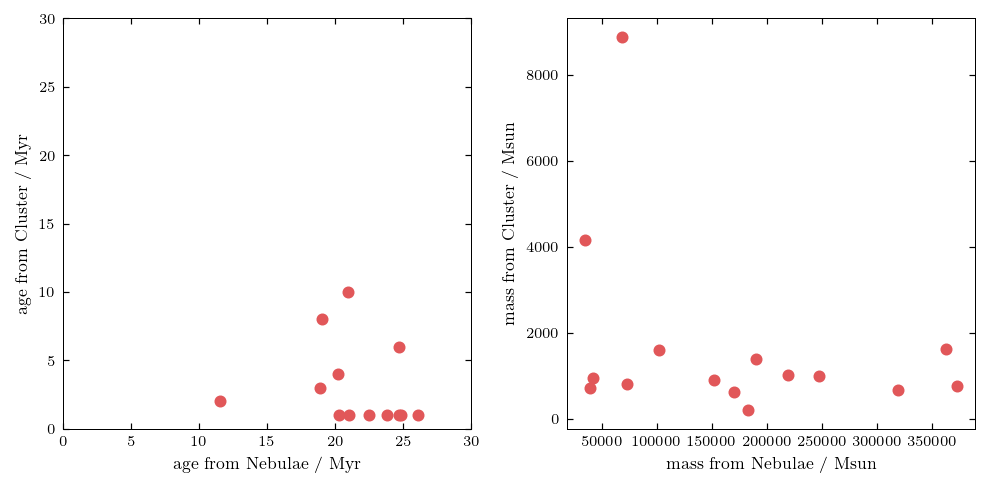

In [102]:
fig,(ax1,ax2) =plt.subplots(nrows=1,ncols=2,figsize=(two_column,two_column/2))

ax1.scatter(np.array(age)/1e6,catalogue['AGE_MINCHISQ'])
ax1.set(ylim=[0,30],xlim=[0,30],xlabel='age from Nebulae / Myr',ylabel='age from Cluster / Myr')

ax2.scatter(np.array(mass),catalogue['MASS_MINCHISQ'])
ax2.set(xlabel='mass from Nebulae / Msun',ylabel='mass from Cluster / Msun')

plt.tight_layout()
plt.show()

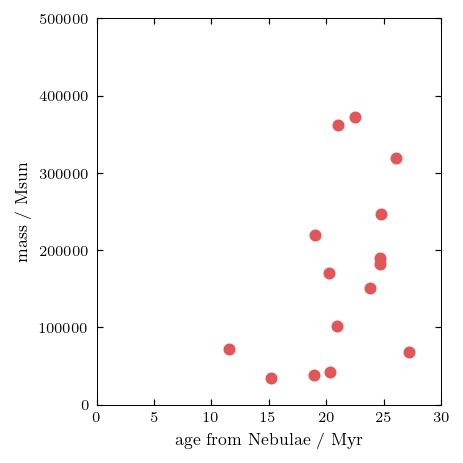

In [106]:
fig,ax1 =plt.subplots(nrows=1,ncols=1,figsize=(single_column,single_column))

ax1.scatter(np.array(age)/1e6,np.array(mass))
ax1.set(xlim=[0,30],ylim=[0,5e5],xlabel='age from Nebulae / Myr',ylabel='mass / Msun')

plt.tight_layout()
plt.show()

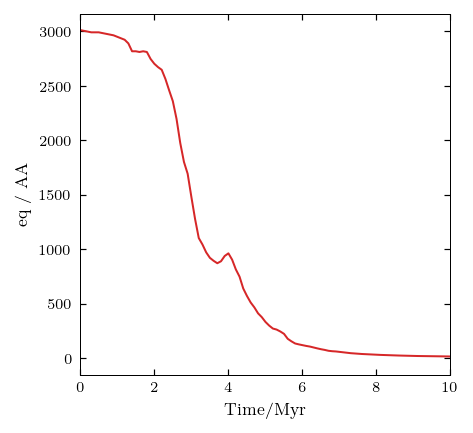

In [19]:
fig,ax1 =plt.subplots(figsize=(single_column,single_column))
eqwHA  = cluster.ewidth['Equ_width_H_A']
time_HA = cluster.ewidth['Time']

ax1.plot(time_HA/1e6,eqwHA,color='tab:red')
ax1.set(xlabel='Time/Myr',ylabel='eq / AA',xlim=[0,10])

#ax2 = ax1.twinx() 
#ax2.plot(time_FUV/1e6,FUV,color='tab:green')
#ax2.set_ylabel('FUV / (erg/s)',color='tab:green')
#ax2.set(xlabel='Time/Myr',xlim=[0,10])
plt.show()

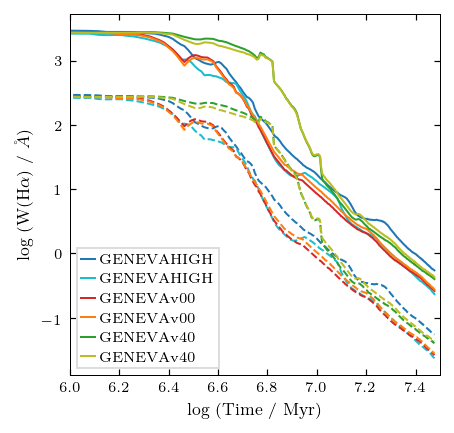

In [21]:
fig,ax1 =plt.subplots(figsize=(single_column,single_column))
colors = ['tab:blue','tab:cyan','tab:red','tab:orange','tab:green','tab:olive']

for m,c in zip([23,24,53,54,63,64],colors):
    
    cl = clusters[m]
    
    eqwHA  = cl.ewidth['Equ_width_H_A']
    time_HA = cl.ewidth['Time']
    ax1.plot(np.log10(time_HA/u.yr),np.log10(eqwHA/u.angstrom),label=f'{cl.stellar_model }',color=c)
    
    sl = cl.scale(1e5)

    eqwHA  = sl.ewidth['Equ_width_H_A']
    time_HA = sl.ewidth['Time']
    ax1.plot(np.log10(time_HA/u.yr),np.log10(eqwHA/u.angstrom),ls='--',color=c)
    
    
ax1.set(xlabel='log (Time / Myr)',ylabel=r'log (W(H$\alpha$) / $\AA$)',xlim=[6,7.5])
ax1.legend()
plt.savefig(basedir/'reports'/'equivalent_width_vs_age.pdf',dpi=600)
plt.show()

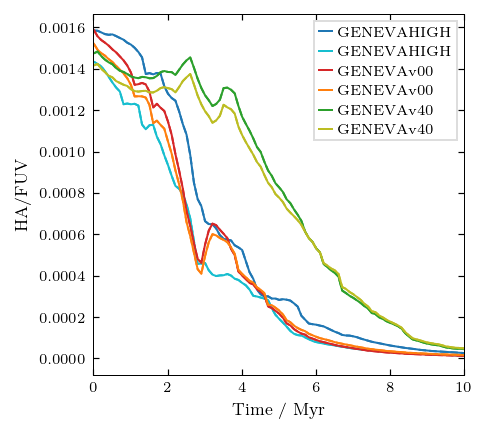

In [23]:
fig,ax1 =plt.subplots(figsize=(single_column,single_column))
colors = ['tab:blue','tab:cyan','tab:red','tab:orange','tab:green','tab:olive']

for m,c in zip([23,24,53,54,63,64],colors):
    
    cl = clusters[m]
    
    HAFUV  = cl.ewidth['Luminosity_H_A'] / cl.FUV['FUV']
    time_HA = cl.ewidth['Time']
    ax1.plot(time_HA/1e6,HAFUV,label=f'{cl.stellar_model }',color=c)
    
    sl = cl.scale(1e5)
    HAFUV  = sl.ewidth['Luminosity_H_A'] / sl.FUV['FUV']
    time_HA = sl.ewidth['Time']
    ax1.plot(time_HA/1e6,HAFUV,ls='--',color=c)    
    
ax1.set(xlabel='Time / Myr',ylabel=r'HA/FUV',xlim=[0,10])
ax1.legend()
#plt.savefig(basedir/'reports'/'equivalent_width_vs_age.pdf',dpi=600)
plt.show()

### Create custom cluster

In [ ]:
def create_cluster(folder,**kwargs):

    parameters = {
    "name" : 'standard',
    "isf" : -1,
    "mass" : 1.,
    "sfr" : 1,
    "ninterv" : 2,
    "xponent" : '1.3,2.3',
    "xmaslim" : '0.1,0.5,120',
    "sncut" : 8.,
    "bhcut" : 120.,
    "model" : 64,
    "wind_model" : 0,
    "tinitial" : 0.01,
    "time_scale" : 0,
    "time_step" : 0.1,
    "n_steps" : 1000,
    "tmax" : 50,
    "jmg" : 3,
    "atmos" : 5,
    "metallicity" : 3,
    "uvline" : 1}

    # assign the new parameters
    for k,v in kwargs.items():
        if k in parameters:
            parameters[k] = v
    
    # open tempalte
    with open(basedir/'data'/'input.template') as f:
        template = f.read()
    
    template = template.format(**parameters)

    #write to templae
    with open(folder/'input.out','w') as f:
        f.write(template)
        
        


## Playground

In [ ]:
with fits.open(basedir / 'data' / 'interim' / 'Nebulae_Catalogue.fits') as hdul:
    nebulae = Table(hdul[1].data)
    
nebulae['FUV'][nebulae['gal_name']=='NGC4254'] = np.nan
nebulae['gal_name'][nebulae['gal_name']=='NGC628'] = 'NGC0628'

# write to file
primary_hdu = fits.PrimaryHDU()
table_hdu   = fits.BinTableHDU(nebulae)
hdul = fits.HDUList([primary_hdu, table_hdu])
hdul.writeto(basedir/'data'/'interim'/'Nebulae_Catalogue_with_FUV.fits',overwrite=True)

In [7]:
"'/'".join('Archive\MUSE\DR2\datacubes'.split('\\'))

"Archive'/'MUSE'/'DR2'/'datacubes"

In [9]:
filename = Path('g:')/'Archive'/'MUSE'/'DR2'/'datacubes'/'NGC3351_DATACUBE_FINAL_WCS_Pall_mad.fits'

with fits.open(filename , memmap=True, mode='denywrite') as hdul:
    #cube=SpectralCube(data=hdul[1].data,wcs=WCS(hdul[1].header))
    
    #hdul.info()
    data_cube   = hdul[1].data
    cube_header = hdul[1].header

In [13]:
cube_header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  897                                                  
NAXIS2  =                  896                                                  
NAXIS3  =                 3761                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =       466.8008560156 / Pixel coordinate of reference point            
CRPIX2  =      442.74054900286 / Pixel coordinate of reference point            
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'             